In [3]:
from dotenv import load_dotenv
load_dotenv()

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Evaluation

이번 프로젝트의 워크플로우는 크게 2 종류로 구성되어 있습니다. 

평가를 그에 따라 아래와 같이 진행할 것입니다. 

1. lite 워크플로우 평가
2. router 노드 평가
3. deep 워크플로우 평가 


### Lite 워크플로우 평가
Lite 워크플로우는 최신성을 중점으로 평가하였습니다. 
Ko-freshqa 데이터 셋을 사용해 평가하였으며, 아래 주소에서 확인할 수 있습니다. 

### router 노드 평가

워크플로우가 질문에 따라 질문의 depth를 미리 파악하고, 질의가 단순하고 단일 검색으로 끝날 만한 것이라면,    
router 노드가 lite 워크플로우로 분기합니다. 그에 따라 문제를 정확히 이해하고 어느 정도의 추론이 필요한지 미리 파악하는 것이 중요합니다. 

ko-freshqa 데이터 셋과 deep 노드에서 사용할 만한 쿼리로 데이터 셋을 구성하고, 정확도를 측정하였습니다.    
또한 추론 이유도 함께 뽑아내어 왜 router가 그 노드로 분기시겼는지 확인하였습니다. 

### Deep 워크플로우 평가

딥리서치 워크플로우는 제작된 gold 쿼리 데이터 셋을 사용해 평가하였습니다.   
각 샘플은 **사용자 질문**과 이에 대응하는 **정답 InfluenceReport(JSON)** 으로 구성되어 있으며,   
시스템이 생성한 리포트와 gold 리포트를 비교하는 방식으로 성능을 측정했습니다. 

평가는 다음 두 가지 관점에서 수행했습니다.

* 🟢 **Relaxed Evaluation (완화 평가)**

  * **사실이고, 의미적으로 타당한 대안 답변**까지 인정하는 평가 방식입니다.
  * 시스템 출력이 gold와 정확히 일치하지 않더라도,

    * 동일한 정치인에 대해,
    * 현실에서 실제로 존재하는 정책·사건·기업 관계를 근거 기반으로 설명하고,
    * 질문의 의도(예: “이재명의 정치–경제 영향력 네트워크를 설명하라”)에 **충분히 부합**하는 경우
      **부분 정답 또는 대안 정답**으로 간주합니다.
  * 이때는 LLM-as-Judge 또는 휴먼 리뷰를 활용하여
    0~1 또는 0~5 점수처럼 **연속적인 점수**를 부여하고,
    샘플별 점수를 평균 내어 Relaxed 스코어를 계산합니다.
  * 즉, **“골드와 다르지만 합리적인 다른 해석”**도 성능으로 인정하는 방향의 평가입니다.

* 🔴 **Strict Evaluation (엄격 평가)**

  * gold 리포트에 정의된 **핵심 체인**을 기준으로,

    * 정책/이슈 영역,
    * 산업/섹터,
    * 주요 기업(또는 must_cover 엔티티)가 **충분히 겹치지 않으면 오답**으로 처리하는 방식입니다.   
    
  * 예를 들어, gold가   
    `이재명 → 성남 FC 후원금 → 두산건설·네이버`   
    를 핵심 체인으로 정의했을 때, 시스템이   
    `이재명 → 대북송금 의혹(쌍방울) → 쌍방울그룹·나노스`   
    만을 제시하면, 실제로 존재하는 사건이라 하더라도   
    **gold가 강조한 테마를 포착하지 못한 것**으로 보고 낮은 점수를 부여합니다.   
  * Strict Evaluation에서는 must_cover로 지정한 정책·산업·기업의 **포함 여부**를 중심으로   
    정확도(accuracy) 또는 엔티티 단위 Precision/Recall 등을 집계하여 점수를 산출합니다.   
  * 즉, **“내가 정의한 테마를 얼마나 정확히 따라왔는가”** 를 보는 보수적인 평가입니다.


## Evaluation Agent

### Citation_faithfulness workflow
Hallucination, 실제 기사인지, 추론한 내용이 있는지 평가하는 워크플로우입니다. 

In [4]:
%pwd

'/Users/seyeong/workspace/Upstage_team3/deep_research/evaluation'

In [5]:
import os
from dotenv import load_dotenv
from langchain_google_genai import ChatGoogleGenerativeAI
from eval_graph import CombinedEvalState, combined_eval_app
from typing import Dict, Any, List, Optional


load_dotenv()


async def evaluate_report_evidence(
    model_report: Dict[str, Any],
    gold_report: Optional[Dict[str, Any]] = None,
    question: Optional[str] = None,
) -> Dict[str, Any]:
    """
    Run:
    - Impact Evidence Faithfulness
    - Policy Attribution Consistency
    - (optionally) Gold vs Model report comparison

    for all influence_chains in a single deep research report.

    Returns:
        {
          "chain_results": [... per-chain impact/attribution results ...],
          "gold_eval": {... gold vs model comparison ...} or None
        }
    """
    # If question is not provided explicitly, fall back to question_answer
    # (not ideal, but better than empty)
    question_for_gold = question or model_report.get("question_answer", "") or ""
    chains = model_report.get("influence_chains", [])

    all_chain_results: List[Dict[str, Any]] = []
    gold_eval: Optional[Dict[str, Any]] = None

    for idx, chain in enumerate(chains):
        # Build CombinedEvalState for this chain
        chain_state: CombinedEvalState = {
            "politician": chain.get("politician"),
            "policy": chain.get("policy"),
            "industry_or_sector": chain["industry_or_sector"],
            "companies": chain["companies"],
            "impact_description": chain["impact_description"],
            "question": question_for_gold,
            "evidence": chain.get("evidence", []),
        }

        # Attach gold/model report only once per graph run.
        # evaluate_gold_node will ignore evidence and only use:
        #   - question
        #   - gold_report
        #   - model_report
        if gold_report is not None:
            chain_state["gold_report"] = gold_report
            chain_state["model_report"] = model_report

        # Run the combined evaluation graph:
        # scrape_urls -> evaluate_impact / evaluate_policy_attribution / evaluate_gold -> combine
        result_state = await combined_eval_app.ainvoke(chain_state)

        # Save per-chain metrics
        all_chain_results.append(
            {
                "chain_index": idx,
                "politician": chain.get("politician"),
                "policy": chain.get("policy"),
                "industry_or_sector": chain["industry_or_sector"],
                "companies": chain["companies"],
                "impact_description": chain["impact_description"],
                # Impact Evidence Faithfulness per URL
                "impact_results": [
                    r.model_dump() for r in result_state.get("impact_results", [])
                ],
                # Policy Attribution Consistency per URL
                "attribution_results": [
                    r.model_dump()
                    for r in result_state.get("attribution_results", [])
                ],
            }
        )

        # gold_eval will be the same for every chain, so we just grab it once
        if gold_report is not None and gold_eval is None:
            gold_eval = result_state.get("gold_eval")

    return {
        "chain_results": all_chain_results,
        "gold_eval": gold_eval,
    }



모델의 예시 출력

In [9]:
state = {'report_title': '이재명 정책-산업-기업 연결 분석 (증거 기반)',
 'time_range': '2025년 6월 기준',
 'question_answer': '이재명은 과거 근무 이력과 정책 수혜를 통해 여러 기업 및 산업과 연결되어 있으나, 재정적·자문적 관계는 확인되지 않음',
 'influence_chains': [{'politician': '이재명',
   'policy': '과거 근무 이력',
   'industry_or_sector': '제조업',
   'companies': ['오리엔트정공', '오리엔트바이오'],
   'impact_description': '이재명 후보의 과거 근무 이력으로 인해 관련주가 급등했으나, 기업은 직접적 관계 없음을 공식 부인함',
   'evidence': [{'source_title': '오리엔트시계공장 근무 이력 관련 기사',
     'url': 'https://weekly.donga.com/economy/article/all/11/5359813/1'}]},
  {'politician': '이재명',
   'policy': '신재생에너지 및 기후에너지 정책',
   'industry_or_sector': '재생에너지',
   'companies': ['HD Hyundai Energy Solutions', 'Hanwha Solutions'],
   'impact_description': '신재생에너지 정책 수혜 기업으로 명시됨',
   'evidence': [{'source_title': '재생에너지 정책 수혜 기업 기사',
     'url': 'https://www.yna.co.kr/view/AKR20250602117900008'}]},
  {'politician': '이재명',
   'policy': 'AI 산업 지원',
   'industry_or_sector': '반도체',
   'companies': ['삼성전자', 'SK하이닉스'],
   'impact_description': 'AI 산업 지원 정책의 수혜 기업으로 언급됨',
   'evidence': [{'source_title': 'AI 반도체 수혜 기업 기사',
     'url': 'https://biz.chosun.com/stock/stock_general/2025/06/04/46YIQPA6EZG3RPIOL742EPRGX4/'}]},
  {'politician': '이재명',
   'policy': '지역화폐 확대',
   'industry_or_sector': '핀테크',
   'companies': ['Kona I', 'Webcash'],
   'impact_description': '지역화폐 확대 정책의 수혜 기업으로 언급됨',
   'evidence': [{'source_title': '지역화폐 수혜 기업 기사',
     'url': 'https://www.g-enews.com/article/Securities/2025/06/202506041519069460288320b10e_1'}]}],
 'notes': ''}

In [6]:
state = {'report_title': '윤석열 대통령의 정책 및 산업별 영향력 분석',
 'time_range': '2025-12-03 기준',
 'question_answer': '윤석열 대통령은 에너지 정책 및 원전 확대, 반도체 산업 전략 등을 통해 에너지/원전 산업 및 반도체 산업의 주요 기업들과 연결되어 있습니다. 원전 관련 기업으로는 한국수력원자력, 두산에너빌리티, 삼성물산, 현대엔지니어링, SK그룹이 있으며, 반도체 관련 기업으로는 삼성전자, SK하이닉스, 네이버, 사피온코리아가 있습니다. 다만, 직접적인 로비 또는 금융적 유대에 대한 명확한 증거는 없습니다.',
 'influence_chains': [{'politician': '윤석열',
   'policy': '에너지 정책 및 원전 확대',
   'industry_or_sector': '에너지/원전 산업',
   'companies': ['한국수력원자력', '두산에너빌리티', '삼성물산', '현대엔지니어링', 'SK그룹'],
   'impact_description': '윤석열 정부는 원전 비중 확대 및 에너지 수요효율화 정책을 추진하며 한국수력원자력, 두산에너빌리티, 삼성물산, 현대엔지니어링, SK그룹 등 원전 및 에너지 관련 기업에 직접적인 영향을 미치고 있습니다. 원전 협력업체에 대한 투자 계획도 포함되어 있습니다.',
   'evidence': [{'source_title': '산업뉴스',
     'url': 'https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQH73D821mhgtVYnQQ5UmL2pBq-b7H3VGs3xZzXoiMhpW_mgiHbNgpgmqTjwNKL2nl6zYnImxTFqIPvE1h_nMN-WfP35awVL3ofdBH-m0PQPNnFoIbmDnYydi2HxWyMJpWu6eAgF4qpgqtmxh6X8MZBAzByeqRQprqJe8AY='},
    {'source_title': '한국에너지법학회',
     'url': 'https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQHuJWtPw-qiTGFMBrmfNdkbCamrGKJ9oDQihy4-WOMLteLAlfcqOkgeQy7V8eqqh2zxDEFbo-bXpaOXXEE9L8kKiNWZKRD9lpf_hVaFjX97qHgi54nkyvnv6rdd04-fJPROLAqIHdu_TSH3bhWxjg=='},
    {'source_title': '산경신문',
     'url': 'https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQHDbvouZl4k5XkdwjYDTMVxzMwQfXwCPA982YqfpE1CF4ca0OP54XTOpOm-YPO4f3PacBfFZmAQDU-nwybI54744lUk3CZl3bZrMM8aeNozrWRKzKb9Cyrjo-yvvBkf0LR0LcthEzSl4k1SBtEUoFgAdrnk2_61ycVxzyxIhv5K8OMgABvTzOIrxWDMvH5jz_IlKKJSI8nXP2-8xm5J4o8fRsmmNDGihnL4r56PuV1KCv5sD7NKLoc_Pc4ctQXn2PITODUDzRZCUtvNrp1Iku9IxIVNyVvT-gT2RB1Y6Fp2sRz-iQ2cQCZXvEhQeP5paU7hLRea9baC8bvwIAzJFHSL-8E='}]},
  {'politician': '윤석열',
   'policy': '반도체 산업 전략',
   'industry_or_sector': '반도체 산업',
   'companies': ['삼성전자', 'SK하이닉스', '네이버', '사피온코리아'],
   'impact_description': '윤석열 정부는 반도체 산업을 국가첨단전략산업으로 지정하고 규제 완화 및 세제 혜택을 확대하며 삼성전자, SK하이닉스, 네이버, 사피온코리아 등 반도체 관련 기업에 영향을 미치고 있습니다. K-반도체 벨트 이니셔티브도 추진 중입니다.',
   'evidence': [{'source_title': '김·장 법률사무소',
     'url': 'https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQFCV-zytmHpCk0kpz3PXSVk6lJi30tv-MMABBEtoR6a0MkJglTmx7CFgj_4tYH70KeD_xWiB558t0YN-wQt_TLJZFlegmL6DX9CaBGW5oBf9-T0sjTfMg_1mS9ZbVs0UuUbKJ2sVpLAUUv8cKIEh-1ItOEdROhbSpufz_4jPVm1mAs='},
    {'source_title': '조선일보',
     'url': 'https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQHiOEvSqYvsQmCKD475NduEfynC1XnAWBX9898G7ho3BQIC3FRkpq8nuAV7QRYyYYnJHDQxVGOsslPX52YZU8JofxP8X-xcafX_zQ8YLSo9kJGlsH08xusafxPREnmQThqp6xIBPYSiX8YYMLgHUf835DmSvPy6Tgx2sy2wZHZ3NKed3NzXVNvM7w6WOXrcBPfUhw=='}]}],
 'notes': ''}

### 단일 결과에 대한 평가

평가는 `evaluate_report_evidence`에 의해 이루어집니다.
모델은 3개의 하위 워크플로우에서 평가합니다.

우선, ChatGPT의 딥리서치 결과인 `gold_report`와 Deep Research 워크플로우가 생성한 결과를 비교합니다.

---

#### 1. Gold Report Alignment (골드 리포트 정합성 평가)

**무엇을 평가하는가?**

* 같은 정치인에 대해:

  * ChatGPT Deep Research가 생성한 `gold_report`
  * 우리 Deep Research 워크플로우가 생성한 `model_report`
    이 두 리포트가 **정책·산업·기업·영향관계 측면에서 얼마나 비슷한 구조와 내용을 가지는지**를 평가합니다.

**어떻게 평가하는가?**

* 하나의 노드에서 다음을 비교하도록 LLM을 호출합니다.

  * 두 리포트의 `question_answer`가 같은 정치인의 **핵심 정책 방향과 산업/기업 영향**을 비슷하게 설명하고 있는지
  * `influence_chains` 수준에서

    * 어떤 정책이 등장하는지
    * 어떤 산업/섹터를 다루는지
    * 어떤 기업들이 언급되는지
    * 각 기업/섹터가 **어떤 방향의 영향(수혜/피해, 성장/위축 등)**을 받는 것으로 설명되는지
* 이때 Gold는 “정답 레이블”이라기보다는,

  > *“딥리서치 시스템이 이상적으로 추구하는 레퍼런스 분석”*
  > 으로 취급되며,

  * 모델 리포트가 Gold와 얼마나 구조적으로/내용적으로 가까운지
  * 혹은 Gold에는 없지만 **더 설득력 있거나 추가적인 근거를 가진 설명**을 제시하는지까지 함께 판단하도록 설계할 수 있습니다.

즉, 이 단계는 **“모델 전체 리포트가 우리가 원하는 타입의 분석으로 나왔는지”**를 글로벌하게 비교·평가하는 역할을 합니다.

---

#### 2. Impact Evidence Faithfulness

*(기사 내용 vs 영향 설명 / 할루시네이션 검증)*

**무엇을 평가하는가?**

* 각 `influence_chain` 단위로,

  * `impact_description` (정책이 특정 산업/기업에 어떤 경제적 영향을 줬다고 모델이 주장하는 문장)
  * 해당 체인에 연결된 `evidence` URL들에서 스크래핑한 기사 본문 (`source_text`)
    를 비교해서,

> **“이 영향 설명이 실제 기사 내용에 의해 지지되는지 / 아니면 할루시네이션인지”**

를 평가합니다.

**어떻게 평가하는가?**

* `impact_evidence_faithfulness` 워크플로우는 다음 순서로 동작합니다.

  1. `scrape_urls_node`

     * 각 evidence URL을 열어 텍스트를 가져옵니다.
  2. `evaluate_impact_node`

     * 각 URL별로 LLM에게 다음 정보를 넘겨줍니다.

       * `industry_or_sector`
       * `companies`
       * `impact_description`
       * `source_title`, `url`, `source_text`
       * (옵션) `question` 컨텍스트
     * LLM은 **기사 내용 vs 영향 설명**을 비교해 다음 라벨 중 하나를 반환합니다.

       * `SUPPORTED`
       * `PARTIALLY_SUPPORTED`
       * `UNSUPPORTED`
       * `CONTRADICTED`
       * `NOT_ENOUGH_INFO`
     * 함께 `score`(0.0–1.0), `reasoning`(한국어 설명),
       그리고 기사 본문에서 뽑은 `evidence_spans`(관련 문장들)를 제공합니다.

**이 단계가 측정하는 것**

* 할루시네이션 여부:

  * `SUPPORTED / PARTIALLY_SUPPORTED` 비율이 높으면,
    → 모델이 기사의 근거 범위 내에서 합리적인 영향 설명을 생성하고 있다는 뜻
  * `UNSUPPORTED / CONTRADICTED`가 많으면,
    → 모델이 기사에 없는 내용 또는 반대 내용을 만들어내고 있다는 신호
* 또한, **영향 설명의 디테일(수치, 방향성, 수혜/피해 여부 등)이 기사와 얼마나 일치하는지**를 직접적으로 측정합니다.

---

#### 3. Policy Attribution Consistency

*(정치인·정책과 기사/URL의 관련성 평가)*

**무엇을 평가하는가?**

* 각 `influence_chain` 단위로,

  * 지정된 `politician` + `policy`
  * 해당 체인의 evidence URL로부터 가져온 기사
    사이의 **연관성**을 측정합니다.

> “이 URL은 정말로
> 이 정치인/정책과 관련된 기사인가?”
> “아니면 단지 산업/기업 이름만 같을 뿐, 정책·정치 맥락은 거의 없는 기사인가?”

**어떻게 평가하는가?**

* `policy_attribution_consistency` 워크플로우는 다음을 수행합니다.

  1. URL 스크래핑은 Impact와 동일하게 `scrape_urls_node`에서 처리 (공유)
  2. `evaluate_policy_attribution_node`에서 각 URL별로 LLM을 호출해 다음을 전달:

     * `politician`, `policy`
     * `industry_or_sector`, `companies`
     * `source_title`, `url`, `source_text`
     * (옵션) 질문 컨텍스트
  3. LLM은 기사와 (politician, policy) 관계를 평가해서:

     * `label`:

       * `HIGHLY_RELATED`
       * `WEAKLY_RELATED`
       * `UNRELATED`
       * `NOT_ENOUGH_INFO`
     * `score`: 0.0–1.0
     * `politician_mentioned`:

       * 기사에서 해당 정치인이 **의미 있게 등장하는지 여부**
     * `policy_topic_mentioned`:

       * 정책 자체 또는 그 핵심 주제(예: 원전 확대, AI 예산, 금산분리 등)가 **실질적으로 다뤄지는지 여부**
     * `evidence_spans`: 관련 구문들
       를 반환합니다.

**이 단계가 측정하는 것**

* **검색/증거 선택 품질**:

  * 모델이 가져온 URL들이 정말 그 정치인과 정책에 관한 기사인지,
  * 아니면 단지 “같은 회사 이름이 잠깐 등장하는 잡다한 기사”인지를 구분합니다.
* 결과적으로, 이 평가는

  * 우리 딥리서치 시스템이 **“정책·정치 맥락에 맞는 근거 기사”**를 잘 고르고 있는지
  * 특정 정치인에게 **관계없는 정책/영향을 억지로 귀속시키고 있지는 않은지**
    를 검증하는 역할을 합니다.

---

#### 4. 세 평가를 합쳐서 보는 관점

정리하면, 단일 결과(한 정치인에 대한 리포트)는 다음 세 축에서 동시에 평가됩니다.

1. **Gold Report Alignment**

   * *“우리가 목표로 삼은 Deep Research 스타일(Gold)과 구조·내용이 비슷한가?”*
   * 정책–산업–기업–영향 체인 구성과 요약 문단 수준에서의 일관성 평가

2. **Impact Evidence Faithfulness (할루시네이션 검증)**

   * *“이 정치인·정책이 기업/산업에 이런 영향을 줬다는 설명이,
     실제 기사 본문과 얼마나 잘 맞는가?”*
   * 기사 근거 기반 vs 모델 생성 내용을 직접 비교

3. **Policy Attribution Consistency (정책 귀속 관련성)**

   * *“이 URL이 정말로 이 정치인과 이 정책에 관한 기사인가?”*
   * 모델의 검색/근거 선택이 정치·정책 맥락에 얼마나 맞는지 평가



In [10]:
gold_entry = {"question": "이재명", "gold_report": {"report_title": "이재명 대통령의 정치·경제 영향력 네트워크 분석", "time_range": "2025년 11월 24일 기준", "question_answer": "이재명 대통령은 AI와 신재생에너지 육성 정책을 통해 삼성전자, 한화솔루션 등 미래 산업 기업들의 성장동력을 마련했으며, 남북 관계 개선 구상을 바탕으로 개성공단 입주 기업과 대북 사업 분야에도 긍정적 기대를 불러일으켰습니다. 동시에 지역화폐 지원 등 중소상공인 활성화 정책으로 핀테크 기업들의 수혜를 도모하고 있습니다.", "influence_chains": [{"politician": "이재명", "policy": "AI 산업 육성 정책", "industry_or_sector": "ICT/인공지능", "companies": ["네이버", "SK텔레콤"], "impact_description": "이재명 정부는 'AI 3대 강국 도약'을 기치로 AI 연구개발을 적극 지원하고 있습니다. 그 결과 네이버, SK텔레콤 등 국내 AI 선도 기업들이 정부 주도 ‘국가대표 AI 기업’으로 선정되어 AI 모델 개발 프로젝트에 참여하며 주가와 투자심리가 개선되었습니다:contentReference[oaicite:5]{index=5}:contentReference[oaicite:6]{index=6}. 정부의 지속적인 지원으로 해당 기업들은 AI 인프라 확대와 글로벌 경쟁력 강화의 혜택을 보고 있습니다.", "evidence": [{"source_title": "이재명정부 5년 청사진 곧 등장…장밋빛전망 가득한 ‘3대 정책 수혜주’", "url": "https://www.ledesk.co.kr/view.php?uid=13714"}]}, {"politician": "이재명", "policy": "신재생에너지 확대 정책", "industry_or_sector": "에너지/신재생", "companies": ["한화솔루션", "씨에스윈드"], "impact_description": "탄소중립 실현과 에너지 전환 가속화 목표 아래 이재명 정부는 풍력·태양광 산업 육성에 박차를 가하고 있습니다. 이에 따라 국내 1위 태양광 기업 한화솔루션과 풍력 설비 업체 씨에스윈드 등이 정책적 지원으로 실적 개선과 성장성 확보에 긍정적 영향을 받고 있습니다:contentReference[oaicite:7]{index=7}:contentReference[oaicite:8]{index=8}. 또한 전력 인프라 분야 기업들(HD현대일렉트릭 등)도 재생에너지 확대에 따른 투자 확대 수혜주로 부각되었습니다.", "evidence": [{"source_title": "이재명정부 5년 청사진 곧 등장…장밋빛전망 가득한 ‘3대 정책 수혜주’", "url": "https://www.ledesk.co.kr/view.php?uid=13714"}]}, {"politician": "이재명", "policy": "남북 경협 재개 구상", "industry_or_sector": "남북경협/개성공단", "companies": ["좋은사람들", "아난티"], "impact_description": "이재명 대통령이 남북 대화 재개와 접경지역 개발 의지를 밝힘에 따라 개성공단 재가동 등 남북경협 기대감이 높아졌습니다. 이에 개성공단에 공장을 둔 속옷 업체 좋은사람들, 금강산 관광 관련 리조트 사업을 했던 아난티 등의 주가가 급등하는 등 직접적 수혜 기대가 나타났습니다:contentReference[oaicite:9]{index=9}:contentReference[oaicite:10]{index=10}. 정부의 대북 정책 기조 변화로 이들 남북경협 테마 기업들은 향후 장기적 성과에 대한 기대를 모으고 있습니다.", "evidence": [{"source_title": "문재인 정책株, 4대강 복원·개성공단 관련주 급등...테마주는 약세", "url": "https://www.thevaluenews.co.kr/news/6918"}, {"source_title": "남북관계 개선에 남북경협주 들썩", "url": "https://www.ledesk.co.kr/view.php?uid=13714"}]}], "notes": "이재명 대통령의 영향력 분석은 2025년 11월 기준이며, 증권가의 기대 심리와 정책 발표에 따른 시장 반응을 기반으로 작성되었습니다. 일부 연관 기업의 실적 개선은 예상에 따른 것이며 실제 정책 효과는 향후 평가가 필요합니다."}}
# gold_entry = {"question": "윤석열", "gold_report": {"report_title": "윤석열 전 대통령의 정치·경제 영향력 네트워크 분석", "time_range": "2025년 11월 24일 기준", "question_answer": "윤석열 전 대통령은 원전 확대 정책으로 두산에너빌리티와 한국전력 등 원전 관련 기업에 수혜를 주었으며, 동시에 원전 중심 기조는 한화솔루션의 태양광 사업에 부정적 영향을 미쳤습니다. 또한 국방비 증액과 기술 육성 정책으로 방산 및 첨단산업 기업의 성장에 기여했으며, 미국·일본과의 동맹 강화 및 중동 경제협력 확대를 통해 국제적 영향력을 도모했습니다.", "influence_chains": [{"politician": "윤석열", "policy": "원전 확대 정책", "industry_or_sector": "에너지/원전", "companies": ["두산에너빌리티"], "impact_description": "윤석열 정부가 신한울 3·4호기 건설 등 원전 사업을 재개하면서 두산에너빌리티가 원전 주기기 제작 수주와 SMR 기술 개발 지원을 받는 등 직접적 수혜를 입었습니다:contentReference[oaicite:0]{index=0}. 글로벌 에너지 위기 속 원전 수요 증가로 해당 기업의 재무 실적도 개선되었습니다.", "evidence": [{"source_title": "윤석열 정책 수혜주 2편] 전 두산중공업(현 두산에너빌리티), 친원전 ...", "url": "https://contents.premium.naver.com/richplatform/therichplatform/contents/220416185027884GB"}]}, {"politician": "윤석열", "policy": "원전 중심 에너지정책", "industry_or_sector": "신재생에너지/태양광", "companies": ["한화솔루션"], "impact_description": "원전 위주의 에너지 정책으로 국내 태양광 수요가 위축되면서 한화솔루션의 태양광 사업 실적이 부진해졌습니다. 한편 미국의 IRA 정책 등에 힘입어 한화솔루션은 베트남·미국에 투자하며 해외 시장을 공략했고, 국방 분야 SMR 추진으로 일부 수혜를 보았습니다:contentReference[oaicite:1]{index=1}:contentReference[oaicite:2]{index=2}.", "evidence": [{"source_title": "엇갈린 K-태양광 실적⋯OCI 웃고 한화 울고", "url": "https://www.etoday.co.kr/news/view/2524466"}, {"source_title": "[이재명 시대, 이 기업을 주목하라]⑩ 한화솔루션ㆍOCI홀딩스", "url": "https://www.dnews.co.kr/uhtml/view.jsp?idxno=202507031419058310351"}]}, {"politician": "윤석열", "policy": "국방·기술 육성 정책", "industry_or_sector": "방위산업/첨단기술", "companies": ["한화에어로스페이스"], "impact_description": "윤석열 정부는 국방예산 증액과 12대 국가전략기술 육성을 추진하여 한화에어로스페이스 등 방위산업 기업의 수주 확대와 R&D 투자를 뒷받침했습니다:contentReference[oaicite:3]{index=3}:contentReference[oaicite:4]{index=4}. 이를 통해 국내 방산업체들은 첨단 무기 개발과 수출에 탄력을 받았습니다.", "evidence": [{"source_title": "尹 취임 2년차, 정책수혜株가 뜬다…방산·원전·콘텐츠株 주목 - 한국경제", "url": "https://www.hankyung.com/economy/article/2023050451426"}]}], "notes": "모든 정보는 2025년 11월 24일 기준이며, 윤석열 전 대통령의 정책들은 현재 이재명 정부에서 수정 또는 재평가되고 있습니다. 일부 데이터는 언론 보도와 간접 추론을 기반으로 합니다."}}
result = await evaluate_report_evidence(
    model_report=state,
    gold_report=gold_entry["gold_report"],
    question=gold_entry["question"],
)
chain_results = result["chain_results"]
gold_eval = result["gold_eval"]

I0000 00:00:1764746052.135559  420094 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
I0000 00:00:1764746101.452447  420094 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
I0000 00:00:1764746125.298897  420094 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
I0000 00:00:1764746143.977322  420094 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers


In [11]:
chain_results

[{'chain_index': 0,
  'politician': '이재명',
  'policy': '과거 근무 이력',
  'industry_or_sector': '제조업',
  'companies': ['오리엔트정공', '오리엔트바이오'],
  'impact_description': '이재명 후보의 과거 근무 이력으로 인해 관련주가 급등했으나, 기업은 직접적 관계 없음을 공식 부인함',
  'impact_results': [{'url': 'https://weekly.donga.com/economy/article/all/11/5359813/1',
    'source_title': '오리엔트시계공장 근무 이력 관련 기사',
    'http_status': None,
    'ok': False,
    'label': 'NOT_ENOUGH_INFO',
    'score': 0.1,
    'reasoning': '제공된 source_text가 비어 있어 impact_description을 평가할 수 없습니다.',
    'evidence_spans': [],
    'error_type': 'TOO_SHORT'}],
  'attribution_results': [{'url': 'https://weekly.donga.com/economy/article/all/11/5359813/1',
    'source_title': '오리엔트시계공장 근무 이력 관련 기사',
    'http_status': None,
    'ok': False,
    'label': 'NOT_ENOUGH_INFO',
    'score': 0.1,
    'reasoning': '기사 본문 내용이 비어있어 이재명 정치인과 과거 근무 이력 정책 간의 관련성을 판단할 수 없습니다.',
    'evidence_spans': [],
    'error_type': 'TOO_SHORT',
    'politician_mentioned': False,
    'policy_topic_ment

In [16]:
gold_eval

{'similarity_score': 0.75,
 'reasoning': '두 보고서는 이재명 의원의 기본소득 및 친환경 에너지 정책을 공통적으로 다루며 관련 산업과 기업을 유사하게 분석했습니다. 그러나 부동산 정책에서 Gold Report는 민간 시장 규제를, Model Report는 공공 주거 확대를 강조하여 접근 방식이 달랐습니다. Gold Report는 기본소득의 플랫폼 산업 영향과 신재생에너지의 이차전지 산업 연관성을 더 깊이 다루어 더 구체적이고 균형 잡힌 시장 파급 효과 설명을 제공했습니다. Model Report는 긍정적 측면에 집중하는 경향이 있었습니다.',
 'model_unique_points': ['청년 주거 안정화를 위한 공공임대주택 확대 정책과 공공 건설 부문의 영향 분석.',
  '친환경 에너지 전환 정책에서 RE100 지원을 통한 기업의 재생에너지 사용 확대 측면 강조.'],
 'gold_unique_points': ['다주택자 규제 강화를 통한 민간 부동산 시장 안정화 정책과 그에 따른 민간 건설사 영향 분석.',
  '기본소득 정책이 플랫폼 산업 및 특정 온라인 유통 기업에 미치는 영향에 대한 심층 분석.',
  '신재생에너지 정책에서 이차전지 산업 및 관련 기업의 성장 가능성 강조.']}

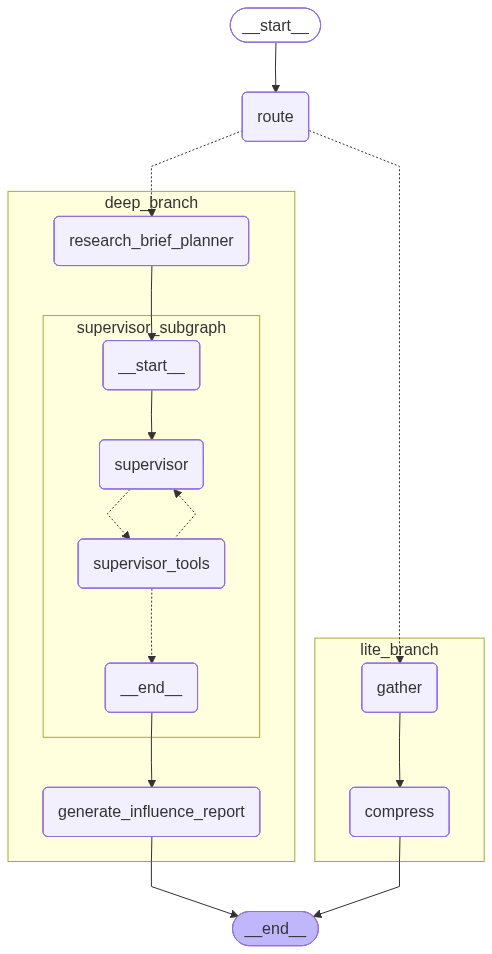

In [4]:
from IPython.display import Image, display
from langgraph.checkpoint.memory import InMemorySaver
from deep_research.router import router_builder

checkpointer = InMemorySaver()
full_agent = router_builder.compile(checkpointer=checkpointer)
display(Image(full_agent.get_graph(xray=-1).draw_mermaid_png()))

In [ ]:


import os
import json
import asyncio
from pathlib import Path
from typing import Any, Dict, List
from uuid import uuid4

from dotenv import load_dotenv
from langchain_core.messages import HumanMessage

load_dotenv()
API_KEY = os.getenv("GOOGLE_API_KEY")


def extract_model_response(result: Dict[str, Any]) -> Dict[str, Any]:
    """
    Extract the structured final_report object from the agent result.
    """
    final_report = result.get("final_report")
    if isinstance(final_report, dict):
        return final_report
    # Fallback: just wrap as dict
    return {"final_report_raw": final_report}


async def generate_model_responses_for_influence(
    gold_jsonl_path: str = "../dev_test/influence_gold.jsonl",
    output_jsonl_path: str = "../dev_test/influence_model_responses_2.jsonl",
    base_thread_id: str = "influence",
) -> None:
    """
    For each line in influence_gold.jsonl:
      - read {"question": "...", "gold_report": {...}}
      - call full_agent with that question
      - extract final_report
      - write {"query": question, "gold_report": ..., "model_response": ...} to output JSONL.

    If output_jsonl already has some entries, skip those queries and only run for the remaining ones.
    """
    gold_path = Path(gold_jsonl_path)
    out_path = Path(output_jsonl_path)

    if not gold_path.exists():
        raise FileNotFoundError(f"Gold file not found: {gold_path}")


    processed_queries: set[str] = set()
    if out_path.exists():
        with out_path.open("r", encoding="utf-8") as f_in:
            for line in f_in:
                line = line.strip()
                if not line:
                    continue
                try:
                    rec = json.loads(line)
                except json.JSONDecodeError:
                    continue
                q = rec.get("query")
                if isinstance(q, str):
                    processed_queries.add(q)

    print(f"[INFO] Already processed {len(processed_queries)} queries")

    with gold_path.open("r", encoding="utf-8") as fin, \
         out_path.open("a", encoding="utf-8") as fout:

        for idx, line in enumerate(fin):
            line = line.strip()
            if not line:
                continue

            record = json.loads(line)
            question = record.get("question")
            if not question:
                continue

            # 이미 처리된 query면 스킵
            if question in processed_queries:
                print(f"[SKIP] already processed query: {question}")
                continue

            thread_config = {
                "configurable": {
                    "thread_id": f"{base_thread_id}-{idx}-{uuid4()}",
                    "recursion_limit": 50,
                }
            }

            print(f"[RUN] query={question} (idx={idx})")

            result = await full_agent.ainvoke(
                {"messages": [HumanMessage(content=question)]},
                config=thread_config,
            )

            model_report = extract_model_response(result)

            out_obj = {
                "query": question,
                "gold_report": record.get("gold_report"),
                "model_response": model_report,
            }

            fout.write(json.dumps(out_obj, ensure_ascii=False) + "\n")
            fout.flush()


await generate_model_responses_for_influence()


[INFO] Already processed 14 queries
[RUN] query=윤석열 (idx=0)
[ROUTER] route=deep, reason=The question consists solely of a politician's name (Yoon Suk-yeol) with no additional context or specific factual request, making the intent ambiguous. Per the SPECIAL RULE, this requires the 'deep' route.
[NAVER] original: 윤석열 전 대통령 2025년 11월 기준 기업 그룹 연계, 정책-기업 이해관계 충돌, 친윤계 정치인 현황
[NAVER] intent  : generic, main_entity=윤석열
[NAVER] queries : ['윤석열 기업 그룹 연계', '윤석열 정책 기업 충돌', '친윤계 정치인 현황', '윤석열 2025년 11월 이해관계', '윤석열 기업 정책 연관성']
[NAVER] original: 윤석열 주요 정책 2025년 11월 기준 경제 목표 입법 현황 주요 이해관계자
[NAVER] intent  : generic, main_entity=윤석열 주요 정책 2025년 11월
[NAVER] queries : ['윤석열 2025 경제 목표', '윤석열 정책 입법 현황', '윤석열 주요 이해관계자', '2025년 11월 정책 현황', '윤석열 경제 정책 목표']


I0000 00:00:1764065060.978744 5379072 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
I0000 00:00:1764065061.009482 5374101 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
I0000 00:00:1764065065.355756 5374101 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
I0000 00:00:1764065065.501084 5379072 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers


[NAVER] original: 윤석열 정책 수혜 기업 로비 활동 2025년 11월
[NAVER] intent  : generic, main_entity=윤석열 정책 수혜 기업 로비 활동
[NAVER] queries : ['윤석열 정책 수혜 기업', '2025년 11월 로비 활동', '윤석열 기업 로비 현황', '정책 수혜 기업 로비', '윤석열 로비 사건 2025', '수혜 기업 로비 조사']


I0000 00:00:1764065067.324222 5374229 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
I0000 00:00:1764065069.420397 5374101 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
I0000 00:00:1764065071.871767 5374229 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
I0000 00:00:1764065071.964754 5379072 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
I0000 00:00:1764065074.795613 5374229 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
I0000 00:00:1764065077.857747 5374229 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
I0000 00:00:1764065082.285020 5374229 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers


[RUN] query=이재명 (idx=1)
[ROUTER] route=deep, reason=The question is an extremely short query consisting solely of a politician's name (이재명) with no additional context or specific factual request, which falls under the SPECIAL RULE requiring the 'deep' route for ambiguous politician-name-only queries.
[NAVER] original: 이재명 정책 수혜 기업 및 주요 후원자 네트워크 2025년 11월 기준
[NAVER] intent  : generic, main_entity=이재명 정책 수혜 기업 및 주요 후원자 네트워크
[NAVER] queries : ['이재명 정책 수혜 기업 2025', '이재명 후원자 네트워크 2025', '이재명 기업 후원 현황', '이재명 정책 기업 지원']


I0000 00:00:1764065191.070848 5374101 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
I0000 00:00:1764065195.412285 5374101 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers


[NAVER] original: 이재명 정책 관련 산업 및 기업 수혜주 2025년 11월
[NAVER] intent  : generic, main_entity=이재명 정책 수혜주
[NAVER] queries : ['이재명 정책 수혜주 2025년 11월', '이재명 정책 관련 산업 수혜주', '이재명 정책 기업 수혜주', '2025년 11월 이재명 수혜주']


I0000 00:00:1764065198.183772 5379072 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
I0000 00:00:1764065200.245264 5374101 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers


[NAVER] original: 이재명 주요 정책 2025년 11월 기준 경제 영향 산업 연결 기업 관계 논란 파트너십
[NAVER] intent  : generic, main_entity=이재명 주요 정책 2025년 11월
[NAVER] queries : ['이재명 정책 경제 영향 2025', '이재명 산업 연결 기업 2025', '이재명 정책 논란 파트너십', '이재명 주요 정책 기업 관계', '이재명 2025년 11월 정책']


I0000 00:00:1764065200.652608 5374229 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
I0000 00:00:1764065201.491940 5379072 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
I0000 00:00:1764065204.838433 5379072 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
I0000 00:00:1764065206.153222 5374229 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
I0000 00:00:1764065207.367562 5379072 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
I0000 00:00:1764065209.840473 5374229 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
I0000 00:00:1764065213.279981 5374229 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
I0000 00:00:1764065215.760326 5374229 fork_posix.cc:71] Other threads are currently calling into gRPC, s

[NAVER] original: 이재명 UAE 방문 동행 기업 및 방산 협력 현황 2025년 11월
[NAVER] intent  : generic, main_entity=이재명 UAE 방문
[NAVER] queries : ['이재명 UAE 방문 기업', '이재명 방산 협력 현황', '이재명 UAE 동행 기업', '이재명 UAE 2025년 11월', '이재명 UAE 방산 협력']


I0000 00:00:1764065231.233861 5374101 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
I0000 00:00:1764065234.538324 5374101 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
I0000 00:00:1764065236.924969 5374101 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers


[RUN] query=문재인 (idx=2)
[ROUTER] route=deep, reason=The question consists solely of a politician's name (Moon Jae-in) with no additional context or specific factual request, making the intent unclear. Per the SPECIAL RULE, this requires the 'deep' route for potential political/industrial analysis.
[NAVER] original: 문재인 대통령 민주당 소속, 에너지·국방·기술 분야 정책 및 한국전력·KAI·네이버와의 관계
[NAVER] intent  : generic, main_entity=문재인 대통령
[NAVER] queries : ['문재인 민주당 소속', '문재인 에너지 정책', '문재인 국방 정책', '문재인 기술 정책', '문재인 한국전력 관계', '문재인 KAI 관계', '문재인 네이버 관계']


I0000 00:00:1764065402.799479 5379072 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
I0000 00:00:1764065406.487916 5379072 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
I0000 00:00:1764065408.859438 5379072 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers


[NAVER] original: 문재인 그린뉴딜 SK그룹 수혜주
[NAVER] intent  : generic, main_entity=문재인 그린뉴딜 SK그룹 수혜주
[NAVER] queries : ['문재인 그린뉴딜 수혜주', 'SK그룹 그린뉴딜 수혜', '그린뉴딜 SK 수혜주', '문재인 정책 SK 수혜주']


I0000 00:00:1764065415.601350 5374229 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
I0000 00:00:1764065419.097992 5374229 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
I0000 00:00:1764065422.532638 5374229 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers


[NAVER] original: 문재인 한국전력 태양광 비리 KAI 방산 수주
[NAVER] intent  : generic, main_entity=문재인 한국전력 태양광 비리 KAI 방산 수주
[NAVER] queries : ['문재인 한국전력 태양광 비리', 'KAI 방산 수주 문재인', '한국전력 태양광 비리 사건', '문재인 정부 방산 수주', 'KAI 방산 비리 문재인']


I0000 00:00:1764065439.035054 5374101 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
I0000 00:00:1764065443.903664 5374101 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
I0000 00:00:1764065447.587117 5374101 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers


[NAVER] original: 문재인 정책 현대차 수혜
[NAVER] intent  : generic, main_entity=문재인 정책 현대차
[NAVER] queries : ['문재인 정책 현대차 수혜', '문재인 정부 현대차 지원', '문재인 현대차 정책 효과', '문재인 현대차 산업 영향']


I0000 00:00:1764065450.023237 5379072 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
I0000 00:00:1764065453.789108 5379072 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
I0000 00:00:1764065457.770858 5379072 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers


[NAVER] original: 문재인 정책 포스코 수혜
[NAVER] intent  : generic, main_entity=문재인 정책 포스코 수혜
[NAVER] queries : ['문재인 정책 포스코 수혜', '문재인 정부 포스코 지원', '포스코 문재인 정책 영향', '문재인 포스코 수혜 기업']


I0000 00:00:1764065486.543043 5374229 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
I0000 00:00:1764065490.101986 5374229 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
I0000 00:00:1764065493.574984 5374229 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
I0000 00:00:1764065496.876762 5374229 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers


[SKIP] already processed query: 박근혜
[SKIP] already processed query: 이명박
[RUN] query=홍준표 (idx=5)
[ROUTER] route=deep, reason=The question consists solely of a politician's name (Hong Joon-pyo) with no additional context or specific factual request, making it an extremely short ambiguous query. Per the SPECIAL RULE, this requires the 'deep' route for potential political/industrial analysis.
[NAVER] original: 홍준표 정책 관련 기업 및 산업 로비스트 연결
[NAVER] intent  : generic, main_entity=홍준표 정책
[NAVER] queries : ['홍준표 정책 로비스트', '홍준표 기업 로비', '홍준표 산업 로비스트', '홍준표 정책 기업 연결', '홍준표 로비스트 산업']


I0000 00:00:1764065599.335275 5379072 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
I0000 00:00:1764065604.325742 5379072 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
I0000 00:00:1764065610.589427 5379072 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers


[SKIP] already processed query: 안철수
[SKIP] already processed query: 이준석
[SKIP] already processed query: 심상정
[SKIP] already processed query: Joe Biden
[RUN] query=Donald Trump (idx=10)
[ROUTER] route=deep, reason=The question is an extremely short query consisting solely of a politician's name (Donald Trump) with no additional context or specific factual request, making the intent unclear. Per the SPECIAL RULE, this requires the 'deep' route.
[SKIP] already processed query: Xi Jinping
[SKIP] already processed query: Vladimir Putin
[SKIP] already processed query: Narendra Modi
[SKIP] already processed query: Rishi Sunak
[SKIP] already processed query: Emmanuel Macron
[SKIP] already processed query: Volodymyr Zelensky
[SKIP] already processed query: Fumio Kishida
[SKIP] already processed query: Mohammed bin Salman


In [11]:
import json
import asyncio
from pathlib import Path


async def evaluate_influence_reports(
    input_jsonl_path: str = "../dev_test/influence_model_responses.jsonl",
    output_jsonl_path: str = "../dev_test/influence_model_responses_eval.jsonl",
) -> None:
    """
    input_jsonl_path:
      각 줄이
      {
        "query": "...",
        "gold_report": {...},
        "model_response": {...}
      }
      형태인 JSONL 파일.

    output_jsonl_path:
      같은 정보에 "evaluation" 필드를 추가한 JSONL을 저장.
    """

    in_path = Path(input_jsonl_path)
    out_path = Path(output_jsonl_path)

    if not in_path.exists():
        raise FileNotFoundError(f"Input file not found: {in_path}")

    # 결과 파일 새로 생성 (덮어쓰기)
    with in_path.open("r", encoding="utf-8") as fin, \
         out_path.open("w", encoding="utf-8") as fout:

        for idx, line in enumerate(fin):
            line = line.strip()
            if not line:
                continue

            record = json.loads(line)

            query = record.get("query")
            gold_report = record.get("gold_report")
            model_report = record.get("model_response")

            if not query or not gold_report or not model_report:
                print(f"[WARN] line {idx}: missing fields, skipping")
                continue

            # -----------------------------
            # 핵심: 평가 함수 호출
            # -----------------------------
            result = await evaluate_report_evidence(
                model_report=model_report,
                gold_report=gold_report,
                question=query,
            )

            # 예: 사용하던 방식
            # chain_results = result["chain_results"]
            # gold_eval = result["gold_eval"]

            out_record = {
                "query": query,
                "evaluation": result,          # result 전체를 그냥 넣어둠
                # "chain_results": chain_results,
                # "gold_eval": gold_eval,
            }

            fout.write(json.dumps(out_record, ensure_ascii=False) + "\n")

            if (idx + 1) % 10 == 0:
                print(f"[INFO] processed {idx + 1} lines")

    print(f"[DONE] saved eval JSONL to {out_path}")



In [12]:
await evaluate_influence_reports()

I0000 00:00:1764062024.304445 5369735 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
I0000 00:00:1764062044.478400 5369735 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
I0000 00:00:1764062085.118386 5369735 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
I0000 00:00:1764062125.775501 5369735 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
I0000 00:00:1764062155.569622 5369735 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
I0000 00:00:1764062190.553616 5369735 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
I0000 00:00:1764062212.501744 5369735 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
I0000 00:00:1764062245.793964 5369735 fork_posix.cc:71] Other threads are currently calling into gRPC, s

[INFO] processed 10 lines


I0000 00:00:1764062864.806359 5369735 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
I0000 00:00:1764062898.617519 5369735 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
I0000 00:00:1764062937.813256 5369735 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
I0000 00:00:1764062972.488322 5369735 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
I0000 00:00:1764062994.765042 5369735 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
I0000 00:00:1764062994.770866 5369735 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
I0000 00:00:1764063034.258259 5369735 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
I0000 00:00:1764063089.700715 5369735 fork_posix.cc:71] Other threads are currently calling into gRPC, s

[WARN] line 13: missing fields, skipping


I0000 00:00:1764063269.276115 5369735 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
I0000 00:00:1764063304.929776 5369735 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
I0000 00:00:1764063322.710513 5369735 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
I0000 00:00:1764063359.481672 5369735 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
I0000 00:00:1764063396.154584 5369735 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
I0000 00:00:1764063419.346531 5369735 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
I0000 00:00:1764063419.355807 5369735 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
I0000 00:00:1764063441.334620 5369735 fork_posix.cc:71] Other threads are currently calling into gRPC, s

[DONE] saved eval JSONL to ../dev_test/influence_model_responses_eval.jsonl


In [ ]:
gold_entry = {"question": "이재명", "gold_report": {"report_title": "이재명 대통령의 정치·경제 영향력 네트워크 분석", "time_range": "2025년 11월 24일 기준", "question_answer": "이재명 대통령은 AI와 신재생에너지 육성 정책을 통해 삼성전자, 한화솔루션 등 미래 산업 기업들의 성장동력을 마련했으며, 남북 관계 개선 구상을 바탕으로 개성공단 입주 기업과 대북 사업 분야에도 긍정적 기대를 불러일으켰습니다. 동시에 지역화폐 지원 등 중소상공인 활성화 정책으로 핀테크 기업들의 수혜를 도모하고 있습니다.", "influence_chains": [{"politician": "이재명", "policy": "AI 산업 육성 정책", "industry_or_sector": "ICT/인공지능", "companies": ["네이버", "SK텔레콤"], "impact_description": "이재명 정부는 'AI 3대 강국 도약'을 기치로 AI 연구개발을 적극 지원하고 있습니다. 그 결과 네이버, SK텔레콤 등 국내 AI 선도 기업들이 정부 주도 ‘국가대표 AI 기업’으로 선정되어 AI 모델 개발 프로젝트에 참여하며 주가와 투자심리가 개선되었습니다:contentReference[oaicite:5]{index=5}:contentReference[oaicite:6]{index=6}. 정부의 지속적인 지원으로 해당 기업들은 AI 인프라 확대와 글로벌 경쟁력 강화의 혜택을 보고 있습니다.", "evidence": [{"source_title": "이재명정부 5년 청사진 곧 등장…장밋빛전망 가득한 ‘3대 정책 수혜주’", "url": "https://www.ledesk.co.kr/view.php?uid=13714"}]}, {"politician": "이재명", "policy": "신재생에너지 확대 정책", "industry_or_sector": "에너지/신재생", "companies": ["한화솔루션", "씨에스윈드"], "impact_description": "탄소중립 실현과 에너지 전환 가속화 목표 아래 이재명 정부는 풍력·태양광 산업 육성에 박차를 가하고 있습니다. 이에 따라 국내 1위 태양광 기업 한화솔루션과 풍력 설비 업체 씨에스윈드 등이 정책적 지원으로 실적 개선과 성장성 확보에 긍정적 영향을 받고 있습니다:contentReference[oaicite:7]{index=7}:contentReference[oaicite:8]{index=8}. 또한 전력 인프라 분야 기업들(HD현대일렉트릭 등)도 재생에너지 확대에 따른 투자 확대 수혜주로 부각되었습니다.", "evidence": [{"source_title": "이재명정부 5년 청사진 곧 등장…장밋빛전망 가득한 ‘3대 정책 수혜주’", "url": "https://www.ledesk.co.kr/view.php?uid=13714"}]}, {"politician": "이재명", "policy": "남북 경협 재개 구상", "industry_or_sector": "남북경협/개성공단", "companies": ["좋은사람들", "아난티"], "impact_description": "이재명 대통령이 남북 대화 재개와 접경지역 개발 의지를 밝힘에 따라 개성공단 재가동 등 남북경협 기대감이 높아졌습니다. 이에 개성공단에 공장을 둔 속옷 업체 좋은사람들, 금강산 관광 관련 리조트 사업을 했던 아난티 등의 주가가 급등하는 등 직접적 수혜 기대가 나타났습니다:contentReference[oaicite:9]{index=9}:contentReference[oaicite:10]{index=10}. 정부의 대북 정책 기조 변화로 이들 남북경협 테마 기업들은 향후 장기적 성과에 대한 기대를 모으고 있습니다.", "evidence": [{"source_title": "문재인 정책株, 4대강 복원·개성공단 관련주 급등...테마주는 약세", "url": "https://www.thevaluenews.co.kr/news/6918"}, {"source_title": "남북관계 개선에 남북경협주 들썩", "url": "https://www.ledesk.co.kr/view.php?uid=13714"}]}], "notes": "이재명 대통령의 영향력 분석은 2025년 11월 기준이며, 증권가의 기대 심리와 정책 발표에 따른 시장 반응을 기반으로 작성되었습니다. 일부 연관 기업의 실적 개선은 예상에 따른 것이며 실제 정책 효과는 향후 평가가 필요합니다."}}
result = await evaluate_report_evidence(
    model_report=state,
    gold_report=gold_entry["gold_report"],
    question=gold_entry["question"],
)
chain_results = result["chain_results"]
gold_eval = result["gold_eval"]

In [15]:
from typing import Dict, Any, List, Optional

VERTEX_PREFIX = "vertexaisearch.cloud.google.com/grounding-api-redirect"


def _is_valid_evidence_item(item: Dict[str, Any]) -> bool:
    """
    Return True if this evidence item should be used for scoring.
    Filters out:
      - vertex grounding redirect URLs
      - NOT_ENOUGH_INFO labels
    """
    url = (item.get("url") or "").lower()
    if VERTEX_PREFIX in url:
        return False

    label = item.get("label")
    if label == "NOT_ENOUGH_INFO":
        return False

    return True


def extract_scores_from_record(record: Dict[str, Any]) -> Dict[str, Any]:
    """
    Given a single JSON record like:
      { "query": "...", "evaluation": { ... } }

    Return:
      {
        "impact_scores": [...],
        "attribution_scores": [...],
        "gold_score": float | None
      }

    Filtering:
      - Exclude evidence items whose URL is a vertex grounding redirect
      - Exclude items with label == "NOT_ENOUGH_INFO"
    """
    evaluation = record.get("evaluation", {}) or {}
    chain_results: List[Dict[str, Any]] = evaluation.get("chain_results", []) or []

    impact_scores: List[float] = []
    attribution_scores: List[float] = []

    for chain in chain_results:
        # Impact Evidence scores
        for item in chain.get("impact_results", []) or []:
            if not _is_valid_evidence_item(item):
                continue
            score = item.get("score")
            if isinstance(score, (int, float)):
                impact_scores.append(float(score))

        # Policy Attribution scores
        for item in chain.get("attribution_results", []) or []:
            if not _is_valid_evidence_item(item):
                continue
            score = item.get("score")
            if isinstance(score, (int, float)):
                attribution_scores.append(float(score))

    gold_eval = evaluation.get("gold_eval", {}) or {}
    gold_score = gold_eval.get("similarity_score")
    if not isinstance(gold_score, (int, float)):
        gold_score = None

    return {
        "impact_scores": impact_scores,
        "attribution_scores": attribution_scores,
        "gold_score": gold_score,
    }


def _mean(xs: List[float]) -> Optional[float]:
    return sum(xs) / len(xs) if xs else None


def compute_averages_for_record(record: Dict[str, Any]) -> Dict[str, Optional[float]]:
    """
    For a single record, return average scores for:
      - impact
      - attribution
      - gold similarity

    Example output:
      {
        "impact_avg": 0.35,
        "attribution_avg": 0.62,
        "gold_avg": 0.7
      }
    """
    scores = extract_scores_from_record(record)

    impact_avg = _mean(scores["impact_scores"])
    attribution_avg = _mean(scores["attribution_scores"])
    gold_avg = scores["gold_score"]  # gold은 이미 하나의 값

    return {
        "impact_avg": impact_avg,
        "attribution_avg": attribution_avg,
        "gold_avg": gold_avg,
    }



def compute_averages_from_jsonl(path: str) -> Dict[str, Optional[float]]:
    """
    Read a JSONL file where each line is:
      { "query": "...", "evaluation": {...} }

    Aggregate all valid scores across records and compute global averages.
    """
    p = Path(path)
    if not p.exists():
        raise FileNotFoundError(p)

    all_impact: List[float] = []
    all_attr: List[float] = []
    all_gold: List[float] = []

    with p.open("r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            record: Dict[str, Any] = json.loads(line)

            per = extract_scores_from_record(record)
            all_impact.extend(per["impact_scores"])
            all_attr.extend(per["attribution_scores"])
            if per["gold_score"] is not None:
                all_gold.append(per["gold_score"])

    return {
        "impact_avg": _mean(all_impact),
        "attribution_avg": _mean(all_attr),
        "gold_avg": _mean(all_gold),
    }



In [16]:
compute_averages_from_jsonl("../dev_test/influence_model_responses_eval.jsonl")

{'impact_avg': 0.42187500000000006,
 'attribution_avg': 0.6968749999999999,
 'gold_avg': 0.7194444444444444}